In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf


In [2]:
# Fetch Historical Data for Asian Paints
ticker = "ASIANPAINT.NS"  # NSE ticker symbol for Asian Paints
data = yf.download(ticker, start="2020-01-01", end="2024-12-01")  # Adjust date range if needed
data['Returns'] = data['Adj Close'].pct_change()

# Extract daily returns
returns = data['Returns'].dropna()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Parameters
confidence_level = 0.95
holding_period = 1  # 1-day VaR
portfolio_value = 1000000  # Portfolio value in INR

# VaR Functions
def historical_var(returns, confidence_level):
    sorted_returns = np.sort(returns)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    return sorted_returns[var_index]

def parametric_var(returns, confidence_level):
    mean = np.mean(returns)
    std = np.std(returns)
    var = norm.ppf(1 - confidence_level, loc=mean, scale=std)
    return var

def monte_carlo_var(returns, confidence_level, simulations=10000):
    mean = np.mean(returns)
    std = np.std(returns)
    simulated_returns = np.random.normal(mean, std, simulations)
    var = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    return var, simulated_returns

# CVaR Functions
def historical_cvar(returns, confidence_level):
    var = historical_var(returns, confidence_level)
    return np.mean(returns[returns <= var])

def parametric_cvar(returns, confidence_level):
    var = parametric_var(returns, confidence_level)
    mean = np.mean(returns)
    std = np.std(returns)
    cvar = mean - (std * norm.pdf(norm.ppf(1 - confidence_level)) / (1 - confidence_level))
    return cvar

def monte_carlo_cvar(returns, confidence_level, simulations=10000):
    var, simulated_returns = monte_carlo_var(returns, confidence_level, simulations)
    return np.mean(simulated_returns[simulated_returns <= var])


In [4]:
# Calculate VaR and CVaR for all methods
historical_var_value = historical_var(returns, confidence_level)
parametric_var_value = parametric_var(returns, confidence_level)
monte_carlo_var_value, _ = monte_carlo_var(returns, confidence_level)

historical_cvar_value = historical_cvar(returns, confidence_level)
parametric_cvar_value = parametric_cvar(returns, confidence_level)
monte_carlo_cvar_value = monte_carlo_cvar(returns, confidence_level)


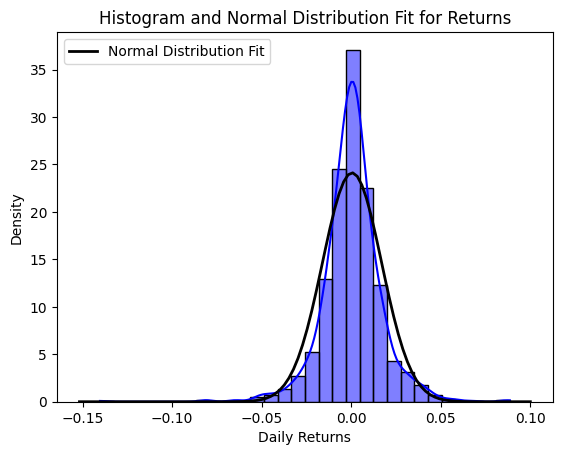

In [5]:
# Plot distribution of returns
sns.histplot(returns, kde=True, color='blue', bins=30, stat="density")
plt.title("Histogram and Normal Distribution Fit for Returns")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(returns), np.std(returns))
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')
plt.legend()
plt.show()


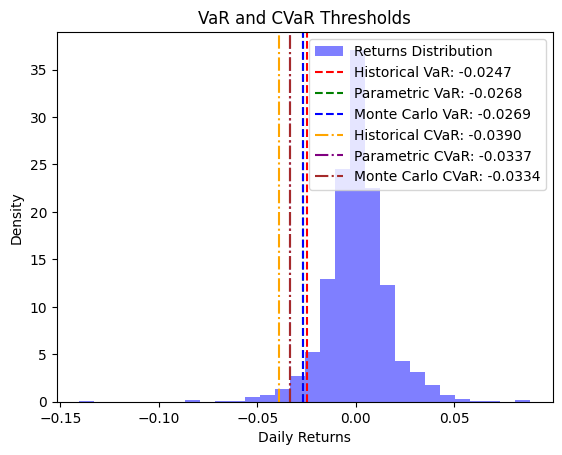

In [6]:
# Plot VaR and CVaR thresholds
plt.hist(returns, bins=30, alpha=0.5, color='blue', density=True, label="Returns Distribution")
plt.axvline(historical_var_value, color='r', linestyle='--', label=f'Historical VaR: {historical_var_value:.4f}')
plt.axvline(parametric_var_value, color='g', linestyle='--', label=f'Parametric VaR: {parametric_var_value:.4f}')
plt.axvline(monte_carlo_var_value, color='b', linestyle='--', label=f'Monte Carlo VaR: {monte_carlo_var_value:.4f}')
plt.axvline(historical_cvar_value, color='orange', linestyle='-.', label=f'Historical CVaR: {historical_cvar_value:.4f}')
plt.axvline(parametric_cvar_value, color='purple', linestyle='-.', label=f'Parametric CVaR: {parametric_cvar_value:.4f}')
plt.axvline(monte_carlo_cvar_value, color='brown', linestyle='-.', label=f'Monte Carlo CVaR: {monte_carlo_cvar_value:.4f}')
plt.title("VaR and CVaR Thresholds")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


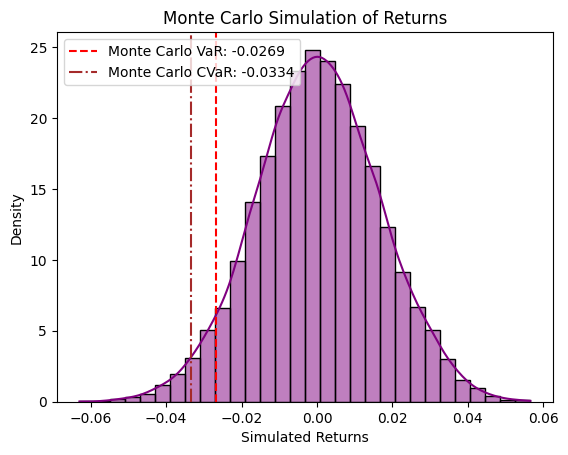

In [7]:
# Monte Carlo Simulation
simulated_returns = np.random.normal(np.mean(returns), np.std(returns), 10000)
sns.histplot(simulated_returns, kde=True, color='purple', bins=30, stat="density")
plt.axvline(monte_carlo_var_value, color='red', linestyle='--', label=f'Monte Carlo VaR: {monte_carlo_var_value:.4f}')
plt.axvline(monte_carlo_cvar_value, color='brown', linestyle='-.', label=f'Monte Carlo CVaR: {monte_carlo_cvar_value:.4f}')
plt.title("Monte Carlo Simulation of Returns")
plt.xlabel("Simulated Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


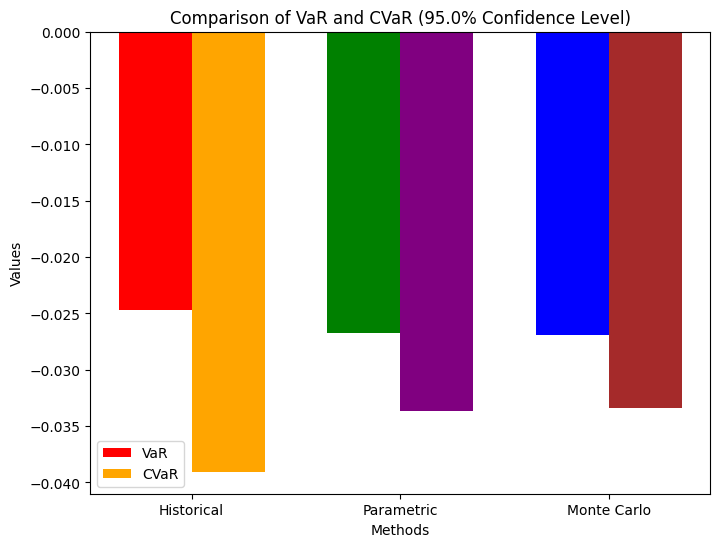

In [8]:
# VaR and CVaR Comparison
methods = ['Historical', 'Parametric', 'Monte Carlo']
var_values = [historical_var_value, parametric_var_value, monte_carlo_var_value]
cvar_values = [historical_cvar_value, parametric_cvar_value, monte_carlo_cvar_value]

fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
x = np.arange(len(methods))
bar1 = ax.bar(x - width / 2, var_values, width, label='VaR', color=['red', 'green', 'blue'])
bar2 = ax.bar(x + width / 2, cvar_values, width, label='CVaR', color=['orange', 'purple', 'brown'])

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_xlabel("Methods")
ax.set_ylabel("Values")
ax.set_title(f"Comparison of VaR and CVaR ({confidence_level * 100}% Confidence Level)")
ax.legend()
plt.show()
